In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Load dataset

In [2]:
test_df = pd.read_csv("test.csv").set_index("Id")
train_df = pd.read_csv("train.csv").set_index("Id")

# Log the target
y = np.log(train_df["SalePrice"])

# put test and train data together so that we can clean it all at once
df = pd.concat([train_df, test_df])
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN


# Looking at the data

In [3]:
df_na = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)
df_na.head(5)

PoolQC         99.657417
MiscFeature    96.402878
Alley          93.216855
Fence          80.438506
SalePrice      49.982871
dtype: float64

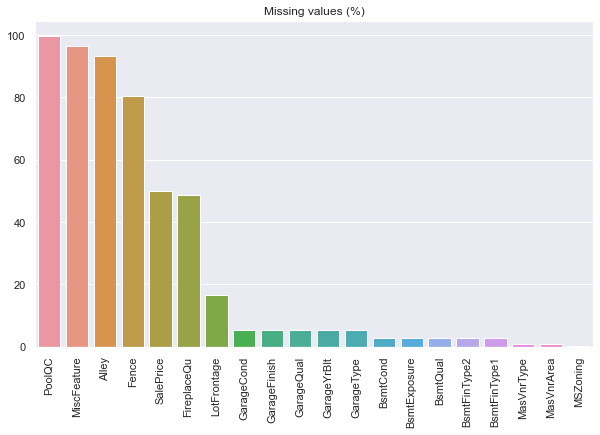

In [4]:
sns.set()
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Missing values (%)")
sns.barplot(x=(df_na.head(20).index), y=df_na.head(20).values)
ax.set_xticklabels((df_na.head(20).index), rotation=90)
plt.show()

<AxesSubplot:>

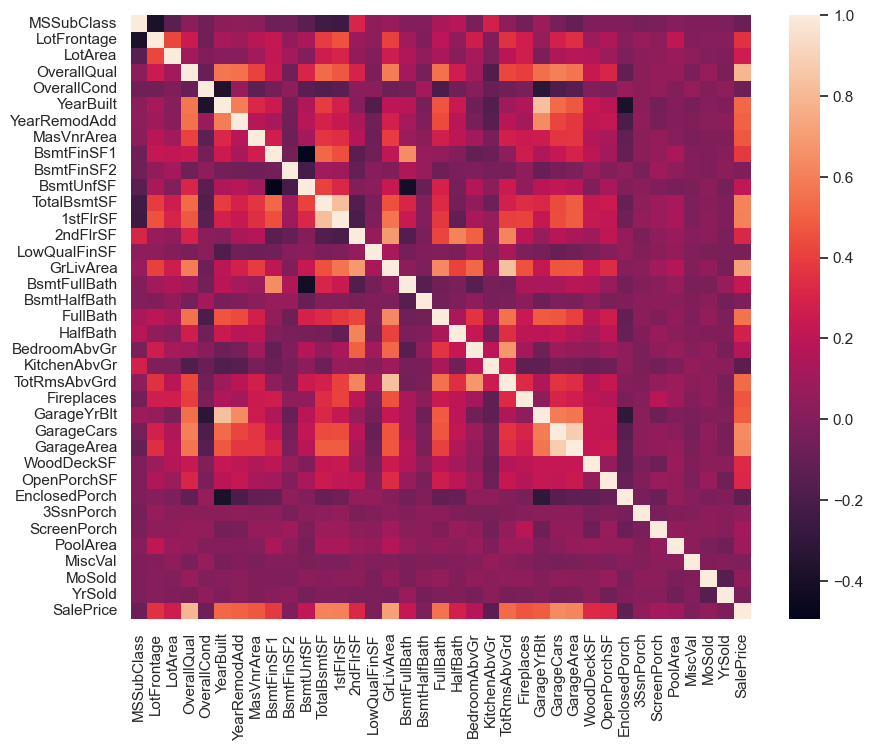

In [5]:
corrmat = train_df.corr()
plt.subplots(figsize=(10, 8), dpi=100)
sns.heatmap(corrmat)

In [6]:
# Sum of the numeric (int) features are categorical so lets not put include them into our nums list
num_cols = [col for col in df.columns if df[col].dtypes in [float, int] and col not in ["MSSubClass", "OverallQual", "OverallCond", 
                                                                                        "YrSold", "MoSold", "YearRemodAdd", "SalePrice"]]
obj_cols = [col for col in df.columns if df[col].dtypes == "object"]

# We know that MSSubClass, OverallQual, and OverallCond are categorical variables but they are held as int types.
# Lets add them to a new list that holds categorical columns and turn them into category type features
cat_cols = ["MSSubClass", "OverallQual", "OverallCond", "YrSold", "MoSold", "YearRemodAdd"] + obj_cols

# The list above holds all categorical features
# But lets make a subset of categorical features that will be used for ordinal encoding (rather than one-hot)
ord_cols = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
           'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MSSubClass', 'Functional', 
            "YrSold", "MoSold", "YearRemodAdd", "Alley", "LotShape", "LandSlope", 
            "Utilities", "CentralAir", "Electrical"]

# The remaining categoricals (nominal) will be one-hot encoded
nominal_cols = [col for col in df.columns if df[col].dtypes == "object" and col not in ord_cols]

/Users/kelstonchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


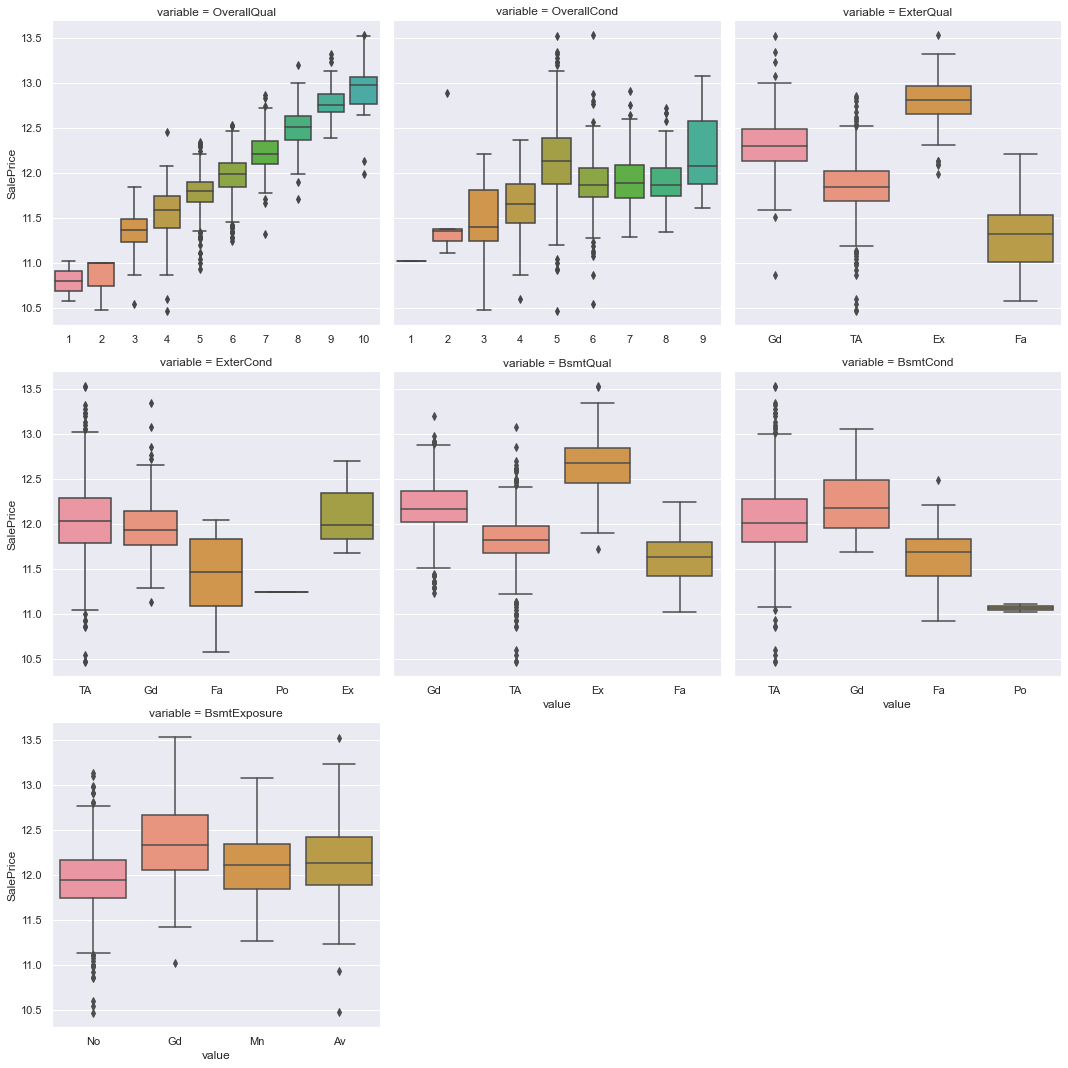

In [7]:
# We can use boxplots to look at the relation between some of the categorical features and the target
def box_plots(df, features):
    df["SalePrice"] = np.log(df["SalePrice"])
    sns.set()
    sns.catplot(x="value", y="SalePrice", col="variable", 
                data=train_df.melt(id_vars="SalePrice", value_vars=features), kind="box", sharex=False, height=5, aspect=1, col_wrap=3)
    plt.tight_layout()
    
box_plots(train_df, ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure'])

**We can see that many of the ordinal features are not actually set in their particular orders that they should be**

**This should be changed**

In [8]:
# This code was taken from "Feature Engineering for House Prices", on Kaggle
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"]
}

# Pre-Processing the data

## Establishing a preliminary dataset

In [9]:
def process_data(train, test, drop_y=True):
    # put the training and test set together, so that we can transform the data in one go
    df = pd.concat([train, test])
    if drop_y == True:
        df = df.drop("SalePrice", axis=1)
    
    ## imputing before encoding here ##
    imputed = impute(df)
    encoded = encode(imputed)
    final_df = set_types(encoded)

    # split the data back into training and test sets
    train_df = final_df.loc[train.index, :]
    test_df = final_df.loc[test.index, :]
    return train_df, test_df

In [10]:
from pandas.api.types import CategoricalDtype

def categorize(df, cols=cat_cols):
    return pd.concat([df[num_cols], df[cols].astype("category")], axis=1)

def impute(df):
    # This returns a completed dataframe
    imputer = SimpleImputer(strategy="most_frequent")
    imp_df = pd.DataFrame(imputer.fit_transform(df))
    imp_df.index = df.index
    imp_df.columns = df.columns
    return imp_df

def encode(df, make_dummys=False, ordered_levels=ordered_levels, ord_cols=ord_cols, nom_cols=nominal_cols):
    """
    Here I use pd.factorize and LabelEncoder to encode the data,
    both do the exact same, they are just implemented slightly differently.
    One being a sklearn function and the other being a pandas function.
    
    I also have some code snippets to generate dummy variables, however,
    dummy variables and ordinal variables are treated the same in Tree models, and since 
    ordinal variables is cleaning and easier to look at, we will no create any dummy variables. 
    (Not here anyways)
    
    """
    # Encoding ordinal variables that DO need to be ordered
    df = df.copy()
    for key, vals in ordered_levels.items():
        df[key] = df[key].astype(CategoricalDtype(categories=vals, ordered=True))
        # Order the ordinal values after encoding
        codes, uniques = pd.factorize(df[key], sort=True)
        df[key] = codes
        
    """
    Ordered_levels and ord_cols share the same columns.
    Need to isolate the columns in ord_cols that are NOT in the ordered_levels.
    
    """
    ord_cols = [col for col in cat_cols if col not in ordered_levels] ## CHANGED "ord_cols" to "cat_cols"
    # Encoding ordinal variables that DO NOT need to be ordered
    lncode = LabelEncoder()
    ord_df = pd.DataFrame()
    for col in ord_cols:
        lncode.fit(list(df[col].values))
        ord_df[col] = lncode.transform(list(df[col].values))
    ord_df.index = df.index
    # One-hot encoding nominal variables
    dummys = pd.get_dummies(df[nom_cols], drop_first=True)
    
    # Putting the final DataFrame together
    df = df.drop((nom_cols + ord_cols), axis=1) # drop the unencoded features
    if make_dummys:
        df = df.join([dummys, ord_df])
    else:
        df = df.join([ord_df]) ## GOT RID OF DUMMYS
    return df

def set_types(df):
    # keep ordinal features as int types
    df[ord_cols] = df[ord_cols].astype(int)
    df[num_cols] = df[num_cols].astype(float)
    cols = [col for col in df.columns if col not in ord_cols and col not in num_cols]
    df[cols] = df[cols].astype(int)
    df["YearBuilt"] = df["YearBuilt"].astype(int)
    return df

In [11]:
train, test = process_data(train_df, test_df)
X = train.copy()
X_test = test.copy()

In [12]:
# X.info(0)

# Check for any missing values left
print(f"Number of missing values: {X.isnull().any().sum()}")

Number of missing values: 0


In [13]:
def score_model(X, y, model=XGBRegressor()):
    score = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

### Baseline Score

In [14]:
# Baseline score before any feature engineering
score_model(X, y)

0.14344665165658171

# Some feature engineering

## Checking correlation with target

In [15]:
corr_w_targ = X.corrwith(y).sort_values(ascending=False)
corr_w_targ.head()

GrLivArea      0.700927
GarageCars     0.680625
ExterQual      0.678840
KitchenQual    0.667893
BsmtQual       0.657131
dtype: float64

In [16]:
high_corr = corr_w_targ.head(12).index
high_corr

Index(['GrLivArea', 'GarageCars', 'ExterQual', 'KitchenQual', 'BsmtQual',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt',
       'OverallQual', 'GarageFinish'],
      dtype='object')

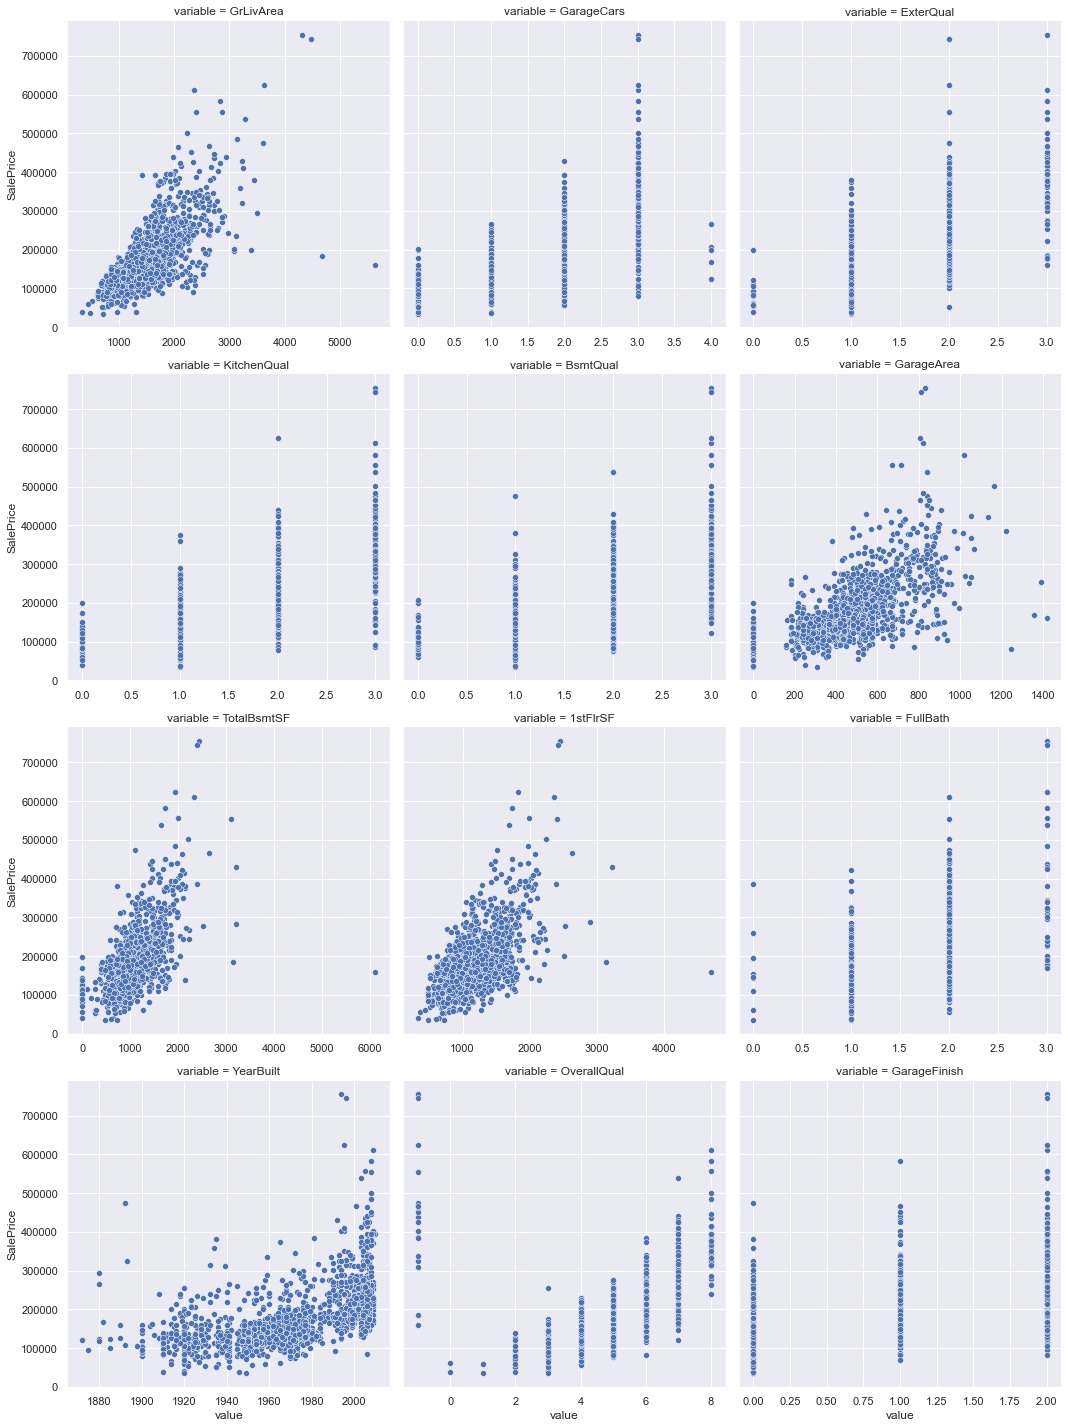

In [17]:
def plot_corrs(df, y=y, cols=high_corr, n_cols=3):
    df = df.join(y)
    df = pd.melt(df, id_vars="SalePrice", value_vars=cols)
    sns.relplot(x=df["value"], y=np.exp(df["SalePrice"]), col=df["variable"], col_wrap=n_cols, facet_kws={"sharex": False})

plot_corrs(X)

## Aggreate some features

In [18]:
# Lets aggreate some features together
X["TotalSF"] = X["1stFlrSF"] + X["2ndFlrSF"] + X["TotalBsmtSF"]
X["OutDoorSF"] = X["WoodDeckSF"] + X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"] + X["PoolArea"]

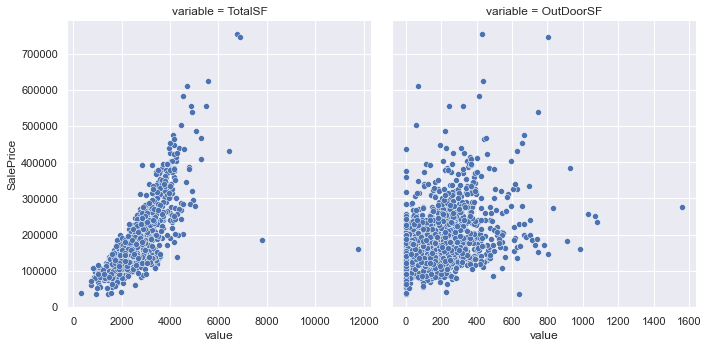

In [19]:
plot_corrs(X, cols=["TotalSF", "OutDoorSF"], n_cols=2)

## Mutual Information

In [20]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    # Create list of discrete features for MI scoring
    # mutual_info_regression takes in a bool array, not an array of column names
    discrete_features = (X.dtypes == int)
    # Make MI scores
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [21]:
mi_scores = make_mi_scores(X, y)
mi_scores

TotalSF         6.852265e-01
OverallQual     5.738365e-01
Neighborhood    5.321705e-01
GrLivArea       4.565544e-01
YearBuilt       4.044703e-01
                    ...     
Utilities       1.887379e-15
MiscFeature     0.000000e+00
3SsnPorch       0.000000e+00
Street          0.000000e+00
MoSold          0.000000e+00
Name: MI Scores, Length: 81, dtype: float64

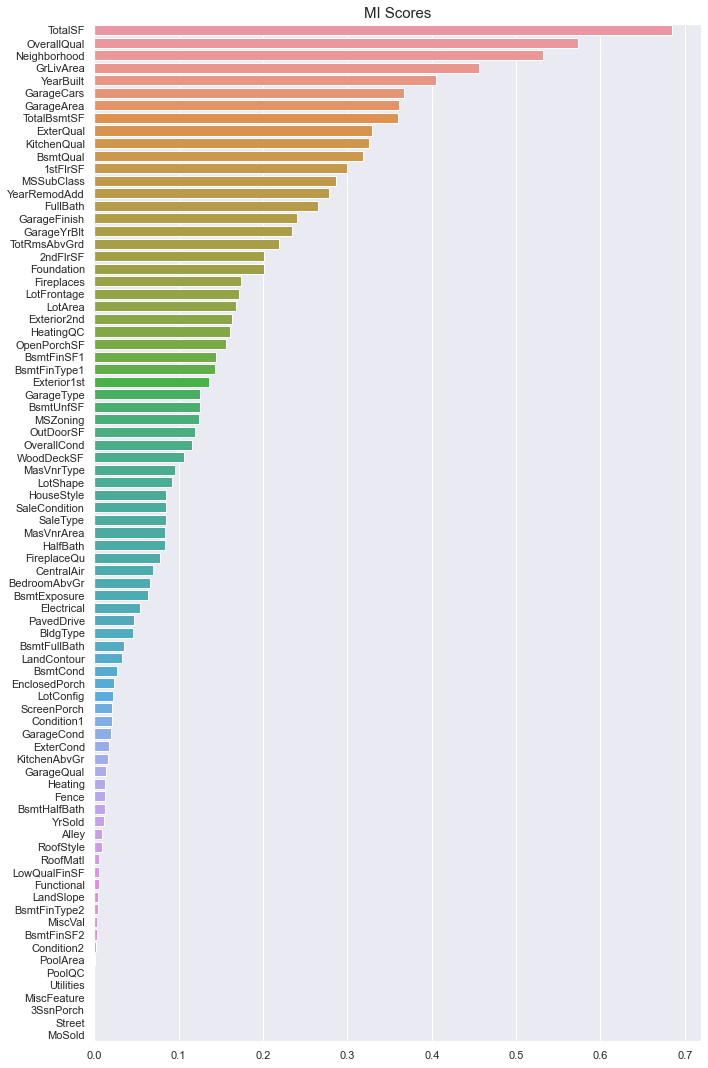

In [22]:
def plot_mi_scores(scores):
    scores = scores
    fig, ax = plt.subplots(figsize=(10, 15))
    sns.barplot(x=scores.values, y=scores.index)
    plt.title("MI Scores", fontsize=15)
    plt.tight_layout()
    
plot_mi_scores(mi_scores)

In [23]:
bottom_mi = mi_scores[49:]
print(round(bottom_mi, 4))

BsmtFullBath     0.0356
LandContour      0.0322
BsmtCond         0.0269
EnclosedPorch    0.0233
LotConfig        0.0218
ScreenPorch      0.0206
Condition1       0.0205
GarageCond       0.0195
ExterCond        0.0179
KitchenAbvGr     0.0168
GarageQual       0.0134
Heating          0.0132
Fence            0.0124
BsmtHalfBath     0.0121
YrSold           0.0109
Alley            0.0089
RoofStyle        0.0086
RoofMatl         0.0059
LowQualFinSF     0.0051
Functional       0.0050
LandSlope        0.0040
BsmtFinType2     0.0040
MiscVal          0.0032
BsmtFinSF2       0.0031
Condition2       0.0021
PoolArea         0.0010
PoolQC           0.0001
Utilities        0.0000
MiscFeature      0.0000
3SsnPorch        0.0000
Street           0.0000
MoSold           0.0000
Name: MI Scores, dtype: float64


## Visual look at low MI features
**We can further investigate, visually, whether some of the low MI features are truly unimportant**

In [24]:
def reg_plot(X, y, hue, cols=mi_scores.index):
    df = X.join(y)
    low_mi = list(cols[4:])
    id_vars = ["SalePrice"] + low_mi
    df = pd.melt(df, id_vars=id_vars, value_vars=cols[:4])
    sns.lmplot(x="value", y="SalePrice", col="variable", hue=hue, data=df, facet_kws={"sharex": False})

In [25]:
# reg_plot(X, y, hue="LandContour")
# reg_plot(X, y, hue="Functional")
# reg_plot(X, y, hue="KitchenAbvGr")

**Function to get rid of zero MI scored features**

In [26]:
def drop_low_mi(X):
    cols = [idx for idx in mi_scores.index if mi_scores[idx] <= 0.0]
    return X.drop(cols, axis=1)

# Feature Creation

Feature creation will include:

* Regular feature creation (mathematical, aggregation, counts)
* Clustering with K-means
* PCA
* Target Encoding

### Regular feature creation

In [27]:
def math_transformations(X):
    df = pd.DataFrame()
    df["TotalSF"] = X["1stFlrSF"] + X["2ndFlrSF"] + X["TotalBsmtSF"]
    df["OutDoorSF"] = X["WoodDeckSF"] + X["OpenPorchSF"] + X["EnclosedPorch"] + X["ScreenPorch"]
    df["LivLotRatio"] = X["GrLivArea"] / X["LotArea"]
    return df

def interactions(X):
    bldgtype = pd.get_dummies(X["BldgType"], prefix="Bldg")
    bldgtype = bldgtype.multiply(X["TotalSF"], axis=0)
    
    contour = pd.get_dummies(X["LandContour"], prefix="LandContour")
    contour = contour.multiply(X["TotalSF"], axis=0)
    
    overallqual = pd.get_dummies(X["OverallQual"], prefix="OverallQual")
    overallqual = overallqual.multiply(X["TotalSF"], axis=0)
    
    neighborhood = pd.get_dummies(X["Neighborhood"], prefix="Neighborhood")
    neighborhood = neighborhood.multiply(X["TotalSF"], axis=0)
    
    kitchens = pd.get_dummies(X["KitchenQual"], prefix="KitchenQual")
    kitchens = kitchens.multiply(X["KitchenAbvGr"], axis=0)
    
    return bldgtype.join([contour, overallqual, neighborhood, kitchens])

def counts(X):
    df = pd.DataFrame()
    df["PorchTypes"] = X[["ScreenPorch",
                         "WoodDeckSF", "OpenPorchSF",
                         "EnclosedPorch"]].gt(0.0).sum(axis=1)
    return df

def group_transforms(X):
    df = pd.DataFrame()
    df["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
    return df

### K-means clustering

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "TotalSF"
]


def kmeans_cluster(X, features, n_clusters=20):
    scaler = StandardScaler()
    df = X.copy()
    
    # standardize data, as it affects clustering
    df_selected = X.loc[:, features]
    df_scaled = pd.DataFrame(scaler.fit_transform(df_selected))
    df_scaled.index = df_selected.index
    df_scaled.columns = df_selected.columns
    
    # cluster the data, and put it into an empty dataframe
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    output_df = pd.DataFrame()
    output_df["Cluster"] = kmeans.fit_predict(df_scaled)
    return output_df

### PCA 

In [29]:
from sklearn.decomposition import PCA

def apply_pca(X):
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(X))
    df_scaled.index = X.index
    df_scaled.columns = X.columns
    pca = PCA()
    df_pca = pca.fit_transform(df_scaled)
     # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
    df_pca = pd.DataFrame(df_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, df_pca, loadings

def pca_components(X, features):
    df = X.loc[:, features]
    _, df_pca, _ = apply_pca(df)
    df_pca.index = X.index
    return df_pca

pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

### Target encoding

In [30]:
from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder

In [31]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

# Putting it together

### Making the final feature set

In [32]:
def create_features(train_df, test_df=None, y=y):
    X = train_df.copy()
    y = y
    mi_scores = make_mi_scores(X, y)
    
    # Check whether the test data frame is passed
    # if so, manipulate the data together, and re-split at the end
    if test_df is not None:
        X_test = test_df.copy()
        # X_test.pop("SalePrice")
        X = pd.concat([X, X_test])
        
    # Drop low MI scored features
    X = drop_low_mi(X)
    
    # Transformations
    X = X.join(math_transformations(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))
    
    # K-Means Clustering
    X = X.join(kmeans_cluster(X, features=cluster_features))
    
    # PCA
    X = X.join(pca_components(X, pca_features))
    
    # Re-split the data
    if test_df is not None:
        X_test = X.loc[test_df.index, :]
        X.drop(df_test.index, inplace=True)
    
    # Target Encoding
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    # encoder = CrossFoldEncoder(CatBoostEncoder, a=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass", "Neighborhood"]))
    if test_df is not None:
        X_test = X_test.join(encoder.transform(X_test))
    
    # Final return, the output
    if test_df is not None:
        return X, X_test
    else:
        return X

In [33]:
df_train, df_test = process_data(train_df, test_df)
train_data = create_features(df_train)

In [34]:
train_data["Cluster"]

Id
1       13.0
2        2.0
3       18.0
4       12.0
5       18.0
        ... 
1456     1.0
1457    12.0
1458    10.0
1459    13.0
1460     NaN
Name: Cluster, Length: 1460, dtype: float64

In [35]:
# Score of model without any hyperparameter tuning
score_model(train_data, y=y)

0.13581741242958786

# Hyperparameter Tuning

In [36]:
params = {
    'learning_rate': np.linspace(0.016, 0.024, 12),
    'max_depth': np.arange(15, 17, 1),
    'subsample': np.linspace(0.42, 0.58, 10),
    'colsample_bytree': np.linspace(0.34, 0.4, 12),
    'n_estimators': np.arange(4290, 5360, 10),
    'min_child_weight': np.linspace(3.2, 4, 20),
    'gamma': np.linspace(0.0058, 0.006, 12),
    'reg_alpha': np.linspace(0.12, 0.196, 10),
    'reg_lambda': np.linspace(1.56, 1.64, 10)
}

xgb_model = XGBRegressor(**params)

In [37]:
def xgb_cv(model, params, X, y):
    
    # Split the data in to training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=50)
    
    # Create empty lists to store output values
    save_params = []
    rmses = []
    accs = []
    
    # Iterate through the parameters 4 times to develop an average value
    i = 0
    while i < 4:
        rs = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=2)
        rs.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)
        # Adding values to lists
        save_params.append(rs.best_params_)
        best_score = rs.best_score_
        rmses.append(np.sqrt(-best_score))
        accs.append(accuracy_score((y_valid).astype(int), rs.predict(X_valid).astype(int)))
        
        print(f"\n============================END OF ITERATION {i+1}============================\n")
        i += 1
    
    # Put the scores and parameters in a dataframe
    scores_df = pd.DataFrame([rmses, accs]).T
    scores_df.columns = ["RMSE", "Accuracy"]
    params_df = pd.DataFrame(save_params, index=np.arange(0, len(save_params)))
    output_df = pd.concat([scores_df, params_df], axis=1)
    
    return output_df

In [38]:
%%time
param_output = xgb_cv(xgb_model, params, train_data, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.34545454545454546, gamma=0.005927272727272727, learning_rate=0.01818181818181818, max_depth=16, min_child_weight=3.5789473684210527, n_estimators=5210, reg_alpha=0.18755555555555556, reg_lambda=1.5866666666666667, subsample=0.5444444444444444; total time=   2.3s
[CV] END colsample_bytree=0.34545454545454546, gamma=0.005927272727272727, learning_rate=0.01818181818181818, max_depth=16, min_child_weight=3.5789473684210527, n_estimators=5210, reg_alpha=0.18755555555555556, reg_lambda=1.5866666666666667, subsample=0.5444444444444444; total time=   2.9s
[CV] END colsample_bytree=0.34545454545454546, gamma=0.005927272727272727, learning_rate=0.01818181818181818, max_depth=16, min_child_weight=3.5789473684210527, n_estimators=5210, reg_alpha=0.18755555555555556, reg_lambda=1.5866666666666667, subsample=0.5444444444444444; total time=   2.7s
[CV] END colsample_bytree=0.34545454545454546, gamma=0.00592727272

In [39]:
param_output.describe().iloc[1:3, :]

,RMSE,Accuracy,subsample,reg_lambda,reg_alpha,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree
mean,0.126665,0.902397,0.522222,1.595556,0.147444,4855.000000,3.568421,15.50000,0.018000,0.005932,0.372727
std,0.000326,0.002873,0.058738,0.007258,0.028740,159.687194,0.086802,0.57735,0.002003,0.000076,0.022268


In [40]:
X_train, X_test = create_features(df_train, df_test)

In [45]:
# xgb_params = {"subsample": 0.54, "reg_lambda": 1.62,
#              "reg_alpha": 0.15, "n_estimators": 4778,
#              "min_child_weight": 3.66, "max_depth": 16,
#              "learning_rate": 0.0187, "gamma": 0.0058,
#              "colsample_bytree": 0.36}
xgb_params = {"subsample": 0.52, "reg_lambda": 1.6,
             "reg_alpha": 0.147, "n_estimators": 4855,
             "min_child_weight": 3.57, "max_depth": 16,
             "learning_rate": 0.018, "gamma": 0.0059,
             "colsample_bytree": 0.37}

In [48]:
xgb_final = XGBRegressor(**xgb_params)
xgb_final.fit(X_train, y)
predictions = xgb_final.predict(X_test)
predictions = np.exp(predictions)

In [49]:
predictions_df = pd.DataFrame((predictions), index=X_test.index, columns=["SalePrice"])

In [52]:
# Outputting some things to CSV format:

# param_output.to_csv("XGB_params_12315")
# predictions_df.to_csv("FeatEng_submission_12315.csv")